## **Приложение доставки**

Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

### Данные с логами заказов пользователей:

- `ab_users_data` – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
- `ab_orders` – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
- `ab_products` – подробная информация о продуктах, их название и стоимость


### План

1. **Препроцессинг данных:**
    - Посмотрим на данные
    
    
2. **Формулировка гипотез:**
    - Сформулируем предположения
    - Выберем метрику
    - Построим графики

    
3. **Тестируем гипотезы:**
     - Выбираем подходящий тест
     - Тестируем
     
     
4. **Подводим итоги:**
    - Сформулировать выводы
    - Какие действия нужно предпринять разработчикам/бизнесу.



In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova 
import pingouin as pg

#sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")
%matplotlib inline

In [2]:
def create_bar_plot_with_customization(data, 
                                       x_column, 
                                       y_column,
                                       colors=None,
                                       title=None, 
                                       x_label=None, 
                                       y_label=None,
                                       legend_1=None,
                                       legend_2=None,
                                       annotate=True,
                                       x_size=16,
                                       y_size=8,
                                       h=50):
    
    # Цвет столбцов
    if colors is None:
        colors ={
                     "0-0": "gray",
                     "0-1": "Orange",
                     "1-0": "gray",
                     "1-1": "Orange"
                 }
    
    plt.figure(figsize=(x_size, y_size))
    ax = sns.barplot(data=data, x=x_column, y=y_column, palette=colors.values(), saturation=0.9)

    # Подпись графика (используем значение по умолчанию, если не указано пользователем)
    if title is not None:
        plt.title(title)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)

    # Легенда (используем значение по умолчанию, если не указано пользователем)
    if legend_1 and legend_2 is not None:
        legend_labels = [plt.Line2D([0], [0], color=color, lw=4, label=legend_1 if color == 'gray' else legend_2) for label, color in list(colors.items())[:2]]
        plt.legend(handles=legend_labels, title='Легенда')
    else:
        legend_labels = [plt.Line2D([0], [0], color=color, lw=4, label=label if color == 'gray' else label) for label, color in list(colors.items())[:2]]
        plt.legend(handles=legend_labels, title='Легенда')
    
    # Значения столбцов
    if annotate:
        for p in ax.patches:
            ax.annotate(f'{round(p.get_height(),1)}', (p.get_x() + p.get_width() / 2., p.get_height() + h), ha='center', va='baseline', fontsize=12, color='black')


## Импорт исходных данных

In [3]:
import requests
from urllib.parse import urlencode

base_url                         = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# Вписываем ссылку  
public_key_ab_users_data         = 'https://disk.yandex.ru/d/4qY27tJ23G_B1g'
public_key_ab_orders             = 'https://disk.yandex.ru/d/prdO8FDQx7lzCg'
public_key_ab_products           = 'https://disk.yandex.ru/d/atwrlmB_wu-fHA'

# Получаем загрузочную ссылку  
final_url_ab_users_data           = base_url + urlencode(dict(public_key=public_key_ab_users_data))
response                          = requests.get(final_url_ab_users_data) # запрос ссылки на скачивание
download_url_ab_users_data        = response.json()['href'] # 'парсинг' ссылки на скачивание

final_url_ab_orders               = base_url + urlencode(dict(public_key=public_key_ab_orders))
response                          = requests.get(final_url_ab_orders) # запрос ссылки на скачивание
download_url_ab_orders            = response.json()['href'] # 'парсинг' ссылки на скачивание

final_url_ab_products             = base_url + urlencode(dict(public_key=public_key_ab_products))
response                          = requests.get(final_url_ab_products) # запрос ссылки на скачивание
download_url_ab_products          = response.json()['href'] # 'парсинг' ссылки на скачивание


# Загружаем файл и сохраняем его
ab_users_data                     = pd.read_csv(download_url_ab_users_data)
ab_orders                         = pd.read_csv(download_url_ab_orders)
ab_products                       = pd.read_csv(download_url_ab_products)


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## 1. **Препроцессинг данных:**

### 1.1. История заказов

In [4]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


### 1.1.1 Общая информация о данных

In [5]:
ab_users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


### 1.1.2 Корректировка формата данных

Столбец `time` необходимо преобразовать в формат времени.

In [6]:
ab_users_data.time = pd.to_datetime(ab_users_data.time , format='%Y-%m-%d %H:%M:%S.%f')

Столбец `date` необходимо преобразовать в формат даты.

In [7]:
ab_users_data.date = pd.to_datetime(ab_users_data.date , format='%Y-%m-%d')

### 1.1.3 Описательная статистика

Отчетный период `2022-08-26` до `2022-09-08` 

In [8]:
ab_users_data.describe(include=['datetime', 'object'], datetime_is_numeric=True)

,action,time,date
count,4337,4337,4337
unique,2,NaN,NaN
top,create_order,NaN,NaN
freq,4123,NaN,NaN
mean,NaN,2022-08-30 14:39:09.155909632,2022-08-30 00:44:49.416647680
min,NaN,2022-08-26 00:00:19,2022-08-26 00:00:00
25%,NaN,2022-08-26 20:14:06,2022-08-26 00:00:00
50%,NaN,2022-08-29 12:37:48,2022-08-29 00:00:00
75%,NaN,2022-09-02 20:43:41,2022-09-02 00:00:00
max,NaN,2022-09-08 23:41:24,2022-09-08 00:00:00


Рассмотрим уникальные значения в столбце `user_id`.\
Столбец `user_id` - включает повторяющиеся значения по id пользователя, поскольку `ab_users_data` содержит исторические данные.

In [9]:
ab_users_data.user_id.nunique()

1017

Рассмотрим уникальные значения в столбце `order_id`.\
Столбец `order_id` - содержи повторяющиеся значения по id заказа. Причины расмотрим далее.

In [10]:
ab_users_data.order_id.nunique()

4123

`action` включает категории `create_order` и `cancel_order`.

In [11]:
ab_users_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

Рассмотрия сколько элементов включает каждая категория.\
Количество по категории `create_order` соответствует уникальным значениям по `order_id` **4 123**.

In [12]:
ab_users_data.action.value_counts()

create_order    4123
cancel_order     214
Name: action, dtype: int64

Проверим на наличие дубликатов отмененные заказы.

Дубликаты отсутствуют.

In [13]:
cancel_order = ab_users_data[ ab_users_data.action == 'cancel_order' ]

In [14]:
cancel_order.order_id.nunique()

214

In [15]:
cancel_order.head()

,user_id,order_id,action,time,date,group
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0
39,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,0
47,995,1298,cancel_order,2022-08-26 00:49:51.514240,2022-08-26,0
54,1002,1308,cancel_order,2022-08-26 00:58:01.924112,2022-08-26,1
60,1008,1315,cancel_order,2022-08-26 01:06:11.292953,2022-08-26,0


Получим список id отмененных заказов.

In [16]:
cancel_order_id = cancel_order.order_id.to_list()

Отфильтруем данные по id отмененных заказов.

In [17]:
doubles = ab_users_data [ ab_users_data.order_id.isin(cancel_order_id) ]

In [18]:
doubles.head()

,user_id,order_id,action,time,date,group
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0
36,993,1296,create_order,2022-08-26 00:39:26.000000,2022-08-26,0
38,995,1298,create_order,2022-08-26 00:43:47.000000,2022-08-26,0
39,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,0


In [19]:
# Используем метод pivot для создания более удобной структуры данных
pivoted = doubles.pivot(index='order_id', columns='action', values='time')
pivoted.head()

action,cancel_order,create_order
order_id,,
1258,2022-08-26 00:08:25.486419,2022-08-26 00:02:56
1296,2022-08-26 00:44:18.150475,2022-08-26 00:39:26
1298,2022-08-26 00:49:51.514240,2022-08-26 00:43:47
1308,2022-08-26 00:58:01.924112,2022-08-26 00:51:54
1315,2022-08-26 01:06:11.292953,2022-08-26 00:58:59


In [20]:
# Выполним сравнение времени между 'create_order' и 'cancel_order'
result = pivoted['create_order'] > pivoted['cancel_order']
result.value_counts()

False    214
dtype: int64

Уберем дубликаты по созданным заказам, оставим отмененные

In [21]:
ab_users_data = ab_users_data [ ~(ab_users_data.order_id.isin(cancel_order_id) & (ab_users_data.action == 'create_order')) ]

### Вывод по п. 1.1.
- Общее количестов заказов **4 337**.
- Столбец `order_id` - содержи повторяющиеся значения по id заказа.
- `order_id` содержит **4 123** уникальных значений заказа из категории `create_order`.
- Категория `cancel_order` включает в себя **214** отмененных заказов, что соотеветствует разнице **d(4 337 - 4 123)**. 
- Следовательно повторение в `order_id` связано с отмененными заказами.
- Повторения в категории `cancel_order` отсутствуют.


1. Поскольку `ab_users_data` содержит исторические данные, следовательно созданные заказы и в псоледствии отмененные, **не выполнены**. Следовательно объем фактически выполненных заказов составляет 4 337 - (214 * 2) = 3 909. 
2. Ошибок в системе учета созданных и отмененных заказав, **не выявленно**. 
3. Принято решение оставить отмененные заказы. Учесть в метрике для оценки работы нового алгоритма, где общее количество будет скоорректировано с учетом невыполненных заказов.Таим образом мы не потеряем информацию о рекомендациях, попавших в отмененные заказы.

In [22]:
df = ab_users_data.groupby(['group', 'action'], as_index=False)\
                  .agg({'user_id': 'count'})\
                  .rename(columns={'user_id': 'count_action'})
df['group_action'] = df.group.astype(str) + "_" + df.action.astype(str)
df

,group,action,count_action,group_action
0,0,cancel_order,82,0_cancel_order
1,0,create_order,1527,0_create_order
2,1,cancel_order,132,1_cancel_order
3,1,create_order,2382,1_create_order


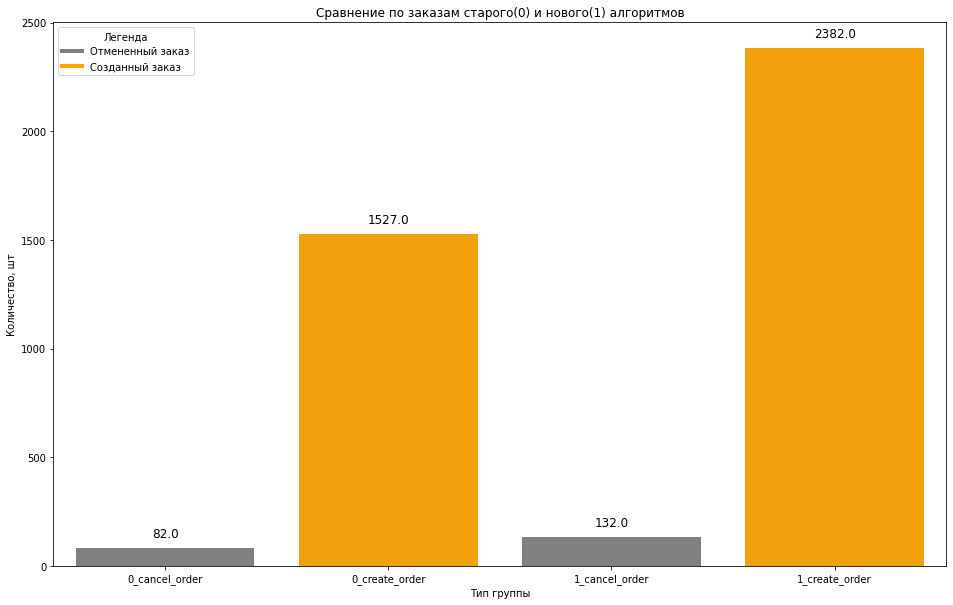

In [23]:
create_bar_plot_with_customization(
                                    data=df,
                                    title='Сравнение по заказам старого(0) и нового(1) алгоритмов',
                                    x_column='group_action',
                                    y_column='count_action',
                                    x_label='Тип группы',
                                    y_label='Количество, шт',
                                    legend_1='Отмененный заказ',
                                    legend_2='Созданный заказ',
                                    annotate=True,
                                    x_size=16,
                                    y_size=10,
                                    colors = {
                                                 "0": "gray",
                                                 "1": "Orange"
                                             }
                                  )

При сравнении по заказам старого(0) и нового(1) алгоритмов, наблюдается прирост объема заказов в абсолютных велечинах. Используем для формулировки гипотиз в **разделе 2**.

**One-Hot Encoding**

Подготовим данные для дальнейшего анализа. 
Чтобы реализовать метрику с учетом категориальных переменных применим функцию под названием pd.get_dummies(). Создадим фиктивные переменные на основе изначальных категорий, представленные в виде 0 и 1.

`action_cancel_order`:

- 0 - заказ создан
- 1 - заказа отменен

Применим к `ab_users_data`:

````python 
df_dummy = pd.get_dummies(data=cars[[список_столбцов_типа_object]], drop_first = True) 
````

In [24]:
ab_users_data = pd.get_dummies(data=ab_users_data, drop_first = False)

In [25]:
ab_users_data = ab_users_data.drop(columns='action_create_order')
ab_users_data

,user_id,order_id,time,date,group,action_cancel_order
0,964,1255,2022-08-26 00:00:19,2022-08-26,0,0
1,965,1256,2022-08-26 00:02:21,2022-08-26,1,0
2,964,1257,2022-08-26 00:02:27,2022-08-26,0,0
4,967,1259,2022-08-26 00:03:37,2022-08-26,1,0
5,968,1261,2022-08-26 00:05:35,2022-08-26,0,0
...,...,...,...,...,...,...
4332,990,59422,2022-09-08 23:13:03,2022-09-08,1,0
4333,1418,59439,2022-09-08 23:18:05,2022-09-08,1,0
4334,1605,59464,2022-09-08 23:22:27,2022-09-08,0,0
4335,1461,59487,2022-09-08 23:29:06,2022-09-08,0,0


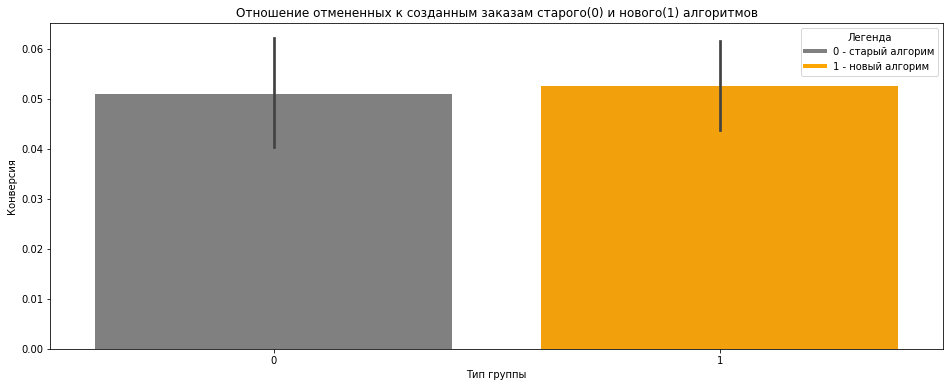

In [26]:
create_bar_plot_with_customization(
                                    data=ab_users_data,
                                    title='Отношение отмененных к созданным заказам старого(0) и нового(1) алгоритмов',
                                    x_column='group',
                                    y_column='action_cancel_order',
                                    x_label='Тип группы',
                                    y_label='Конверсия',
                                    legend_1='0 - старый алгорим',
                                    legend_2='1 - новый алгорим',
                                    annotate=False,
                                    x_size=16,
                                    y_size=6,
                                    colors = {
                                                 "0": "gray",
                                                 "1": "Orange"
                                             }
                                  )

При рассмторении отношения отмененных к созданным заказам, наблюдается незначительный прирост по отмененным заказам. Доверительные интервалы пересикаются. Дальнейший анализ буде проведен в **разделе 2** после формулировки гипотез.

### 1.2. Информация о составе заказа

In [27]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


### 1.2.1 Общая информация о данных

In [28]:
ab_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


### 1.2.2 Корректировка формата данных

Столбец `creation_time` необходимо преобразовать в формат даты и времени.

In [29]:
ab_orders.creation_time = pd.to_datetime(ab_orders.creation_time, format='%Y-%m-%d %H:%M:%S.%f')

### 1.2.3 Описательная статистика

Отчетный период `2022-08-26` до `2022-09-08`. Соответствует п. 1.1.3.

In [30]:
ab_orders.describe(include=['datetime', 'object'], datetime_is_numeric=True)

,creation_time,product_ids
count,4123,4123
unique,NaN,3877
top,NaN,{20}
freq,NaN,11
mean,2022-08-30 14:45:06.142372096,NaN
min,2022-08-26 00:00:19,NaN
25%,2022-08-26 20:14:15.500000,NaN
50%,2022-08-29 12:37:43,NaN
75%,2022-09-02 20:46:49.500000,NaN
max,2022-09-08 23:41:24,NaN


- Рассмотрим состав заказа более подробнее. 
- Оценим как применение нового алгорима повлияло на состав потребительской корзины.
- Преобразуем перечень `product_ids` в список.
- Применим `explode`, чтобы рассмотреть продукты заказа в отдельности.

In [31]:
ab_orders['product_ids'] = ab_orders['product_ids'].str.strip('{}')
ab_orders['product_ids'] = ab_orders['product_ids'].str.split(', ')

In [32]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"[74, 6]"
4,1259,2022-08-26 00:03:37,"[20, 45, 67, 26]"


In [33]:
ab_orders = ab_orders.explode('product_ids')
ab_orders.product_ids = ab_orders.product_ids.astype(int)
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,75
0,1255,2022-08-26 00:00:19,22
0,1255,2022-08-26 00:00:19,53
0,1255,2022-08-26 00:00:19,84
1,1256,2022-08-26 00:02:21,56


### 1.3. Информация о продуктах

In [34]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


### 1.3.1 Общая информация о данных

In [35]:
ab_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


### 1.3.2 Описательная статистика

In [36]:
ab_products.describe(include=['datetime', 'object'], datetime_is_numeric=True)

,name
count,87
unique,87
top,овсянка
freq,1


## 2. Формулировка гипотез

Объеденим данные для дальнейшего анализа.

In [37]:
total_orders = ab_users_data.merge(ab_orders, 
                                   how='left', 
                                   on='order_id')\
                            .merge(ab_products, 
                                   how='left', 
                                   left_on='product_ids', 
                                   right_on='product_id')\
                            .drop(columns=['product_ids', 'creation_time'])

In [38]:
total_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13826 entries, 0 to 13825
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              13826 non-null  int64         
 1   order_id             13826 non-null  int64         
 2   time                 13826 non-null  datetime64[ns]
 3   date                 13826 non-null  datetime64[ns]
 4   group                13826 non-null  int64         
 5   action_cancel_order  13826 non-null  uint8         
 6   product_id           13826 non-null  int64         
 7   name                 13826 non-null  object        
 8   price                13826 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(1), uint8(1)
memory usage: 985.6+ KB


In [39]:
total_orders.head()

,user_id,order_id,time,date,group,action_cancel_order,product_id,name,price
0,964,1255,2022-08-26 00:00:19,2022-08-26,0,0,75,сок ананасовый,120.0
1,964,1255,2022-08-26 00:00:19,2022-08-26,0,0,22,сок мультифрукт,120.0
2,964,1255,2022-08-26 00:00:19,2022-08-26,0,0,53,мука,78.3
3,964,1255,2022-08-26 00:00:19,2022-08-26,0,0,84,мандарины,90.4
4,965,1256,2022-08-26 00:02:21,2022-08-26,1,0,56,сосиски,150.0


### 2.1. Количество заказов

### 2.1.1 Количество заказов по отдельным пользователям

In [40]:
count_action_user_id = ab_users_data.query('action_cancel_order == 0')\
                                    .groupby(['group', 'user_id'], as_index=False)\
                                    .agg({'order_id': 'count'})\
                                    .rename(columns={'order_id': 'count_action_user_id'})
count_action_user_id.head()

,group,user_id,count_action_user_id
0,0,964,2
1,0,968,3
2,0,969,2
3,0,972,1
4,0,975,2


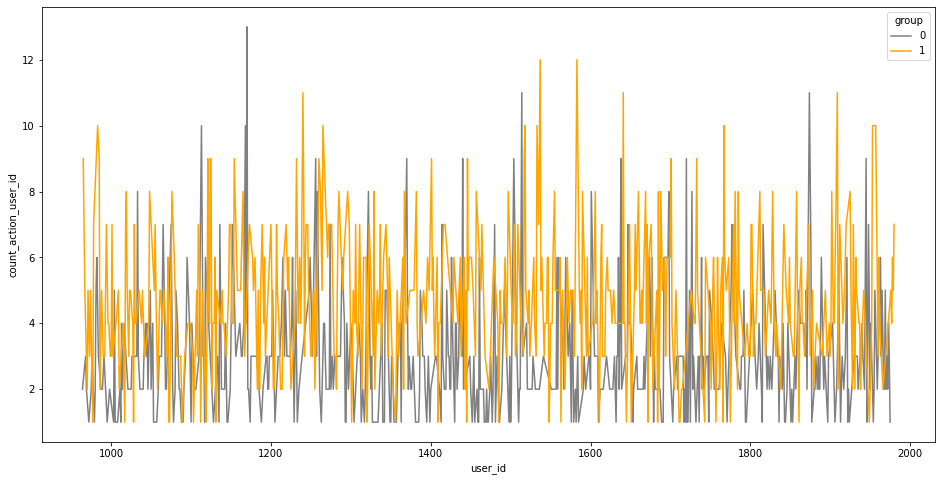

In [41]:
plt.figure(figsize=(16, 8))
colors = {"0": "gray", "1": "Orange"}
sns.lineplot(data=count_action_user_id, x='user_id', y='count_action_user_id', hue='group',palette=colors.values())

### 2.1.2 Количество заказов в целом

In [42]:
total_count_action = count_action_user_id.groupby('group', as_index=False)\
                                         .agg({'count_action_user_id': 'sum'})\
                                         .rename(columns={'count_action_user_id': 'total_count_action'})
total_count_action

,group,total_count_action
0,0,1527
1,1,2382


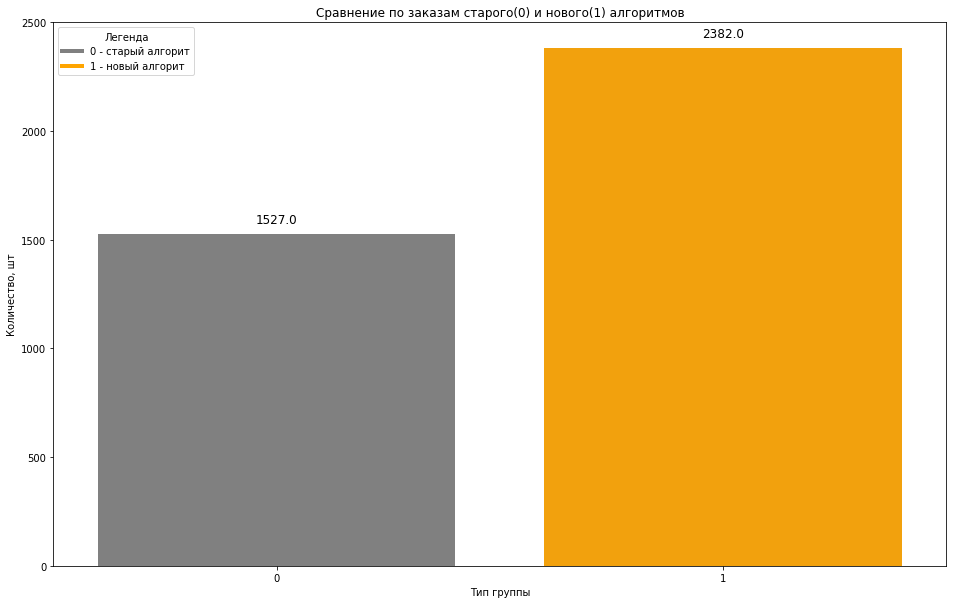

In [43]:
create_bar_plot_with_customization(
                                    data=total_count_action,
                                    title='Сравнение по заказам старого(0) и нового(1) алгоритмов',
                                    x_column='group',
                                    y_column='total_count_action',
                                    x_label='Тип группы',
                                    y_label='Количество, шт',
                                    legend_1='0 - старый алгорит',
                                    legend_2='1 - новый алгорит',
                                    annotate=True,
                                    x_size=16,
                                    y_size=10,
                                    colors = {
                                                 "0": "gray",
                                                 "1": "Orange"
                                             }
                                  )

### 2.2. Выручка

### 2.2.1 Выручка по отдельным пользователям

Рассмотрим, как новый алгоритм рекомендаций повлиял на выручку по отдельным пользователям.\
Учитывать отмененные заказы не будем.

In [44]:
total_price_user_id = total_orders.query('action_cancel_order == 0')\
                                  .groupby(['group','user_id'], as_index=False)\
                                  .agg({'price': 'sum'})\
                                  .rename(columns={'price': 'total_price_user_id'})
total_price_user_id.head()

,group,user_id,total_price_user_id
0,0,964,718.9
1,0,968,1590.7
2,0,969,681.9
3,0,972,546.4
4,0,975,1432.9


По некоторым пользователям выручка уменьшилась.

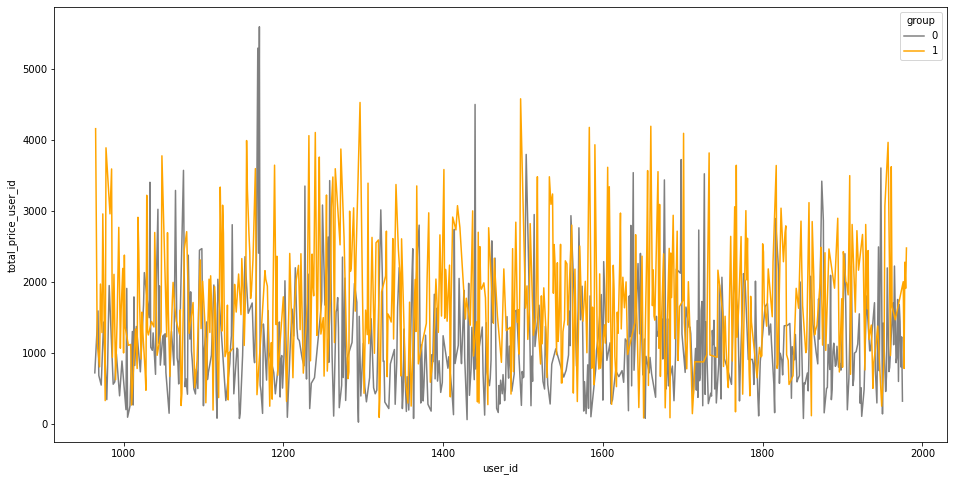

In [45]:
plt.figure(figsize=(16, 8))
colors = {"0": "gray", "1": "Orange"}
sns.lineplot(data=total_price_user_id, x='user_id', y='total_price_user_id', hue='group',palette=colors.values())

### 2.2.2 Выручка в целом

Рассмотрим, как новый алгоритм рекомендаций повлиял на выручку в целом.

In [46]:
total_price = total_price_user_id.groupby('group', as_index=False)\
                                 .agg({'total_price_user_id': 'sum'})\
                                 .rename(columns={'total_price_user_id': 'total_price'})
total_price

,group,total_price
0,0,583455.9
1,1,878628.4


Прирост составил примерно 33,6% относительно выручки из группы 0 - старого алгоритма.

In [47]:
round((1 - (total_price.total_price[0]/total_price.total_price[1])) * 100, 2)

33.59

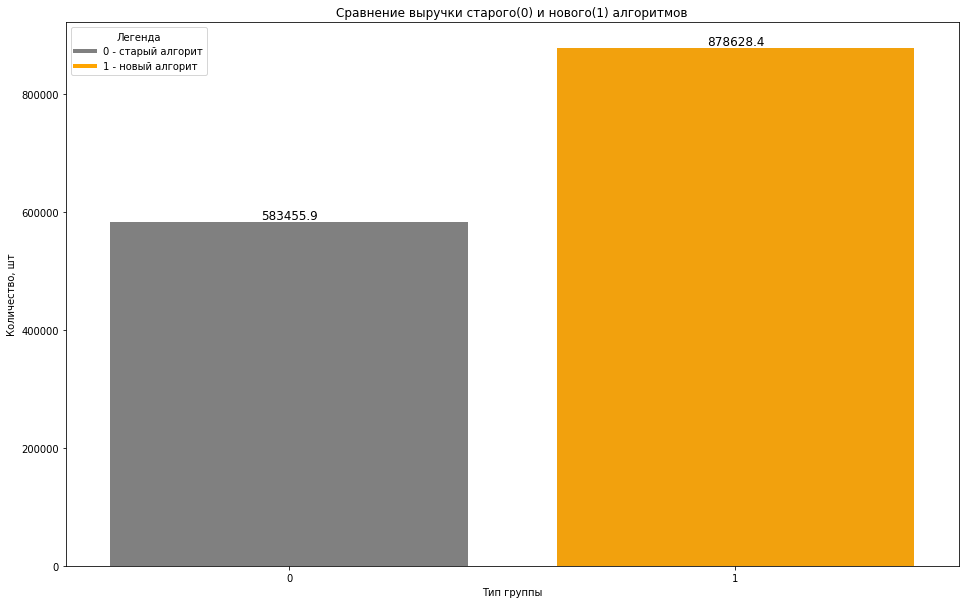

In [48]:
create_bar_plot_with_customization(
                                    data=total_price,
                                    title='Сравнение выручки старого(0) и нового(1) алгоритмов',
                                    x_column='group',
                                    y_column='total_price',
                                    x_label='Тип группы',
                                    y_label='Количество, шт',
                                    legend_1='0 - старый алгорит',
                                    legend_2='1 - новый алгорит',
                                    annotate=True,
                                    x_size=16,
                                    y_size=10,
                                    h=5000,
                                    colors = {
                                                 "0": "gray",
                                                 "1": "Orange"
                                             }
                                  )

### 2.3. Заказ продуктов

### 2.3.1 Заказ отдельных продуктов

Рассмотрим изменение на заказ отдельных продуктов.

In [49]:
count_product = total_orders.query('action_cancel_order == 0')\
                            .groupby(['group','product_id'], as_index=False)\
                            .agg({'order_id': 'count'})\
                            .rename(columns={'order_id': 'count_product'})
count_product.head()

,group,product_id,count_product
0,0,1,93
1,0,2,63
2,0,3,96
3,0,4,37
4,0,5,85


В целом, наблюдается прирост практически по всем позициям.

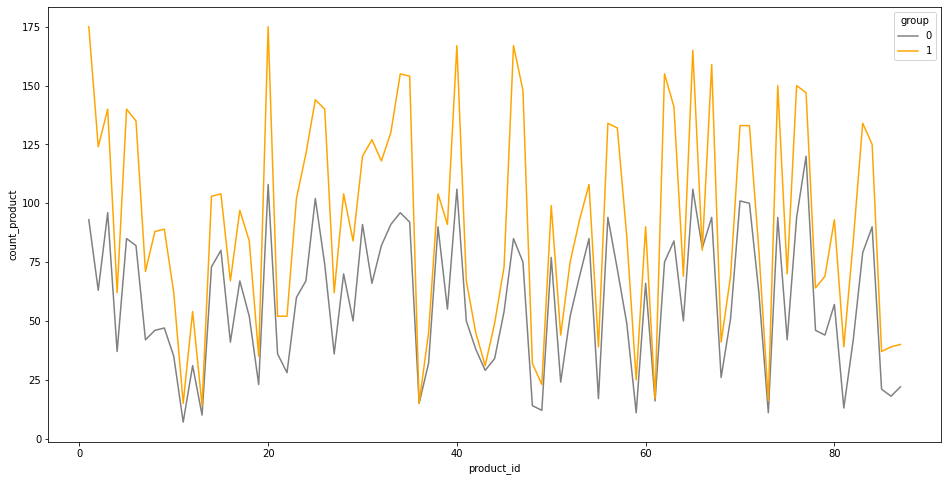

In [50]:
plt.figure(figsize=(16, 8))
colors = {"0": "gray", "1": "Orange"}
sns.lineplot(data=count_product, x='product_id', y='count_product', hue='group',palette=colors.values())

### 2.3.2 Размер потребительской корзины пользователей

In [51]:
count_product_user_id = total_orders.query('action_cancel_order == 0')\
                                    .groupby(['group','user_id'], as_index=False)\
                                    .agg({'product_id': 'count'})\
                                    .rename(columns={'product_id': 'count_product_user_id'})
count_product_user_id.head()

,group,user_id,count_product_user_id
0,0,964,8
1,0,968,11
2,0,969,8
3,0,972,5
4,0,975,11


Схожая картина с п. 2.1.1-2.2.2

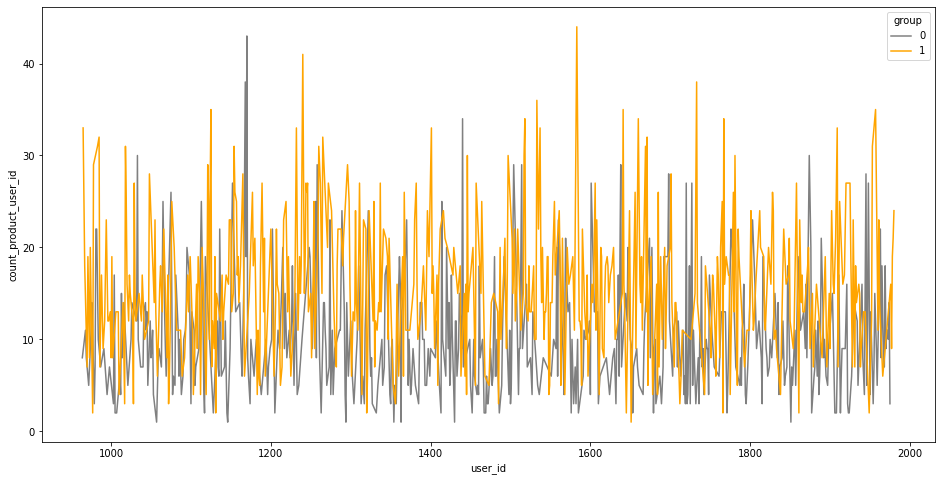

In [52]:
plt.figure(figsize=(16, 8))
colors = {"0": "gray", "1": "Orange"}
sns.lineplot(data=count_product_user_id, x='user_id', y='count_product_user_id', hue='group',palette=colors.values())

### 2.3.3 Заказ продуктов в целом

In [53]:
total_count_product = count_product.groupby('group', as_index=False)\
                                   .agg({'count_product': 'sum'})\
                                   .rename(columns={'count_product': 'total_count_product'})
total_count_product.head()

,group,total_count_product
0,0,5103
1,1,7980


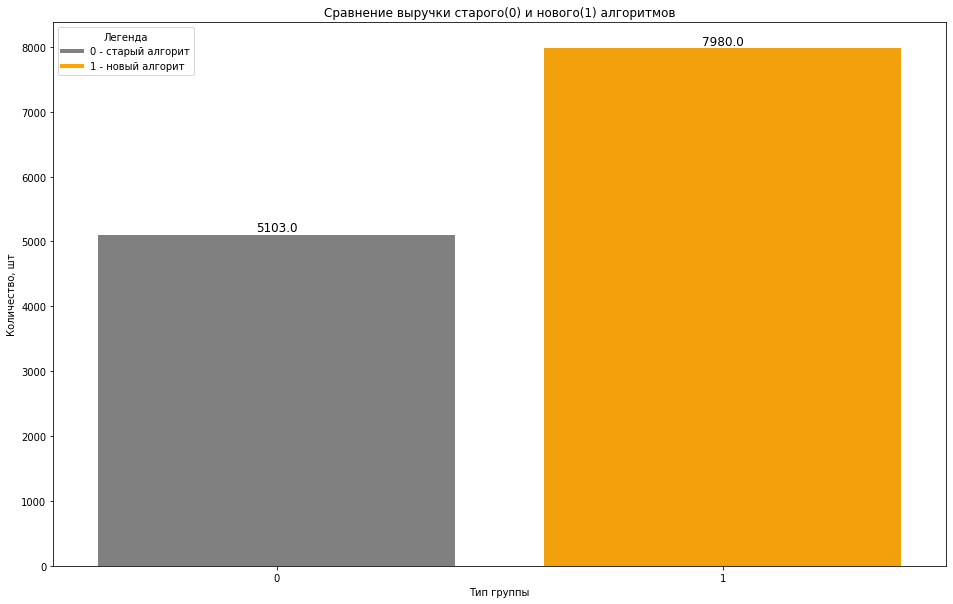

In [54]:
create_bar_plot_with_customization(
                                    data=total_count_product,
                                    title='Сравнение выручки старого(0) и нового(1) алгоритмов',
                                    x_column='group',
                                    y_column='total_count_product',
                                    x_label='Тип группы',
                                    y_label='Количество, шт',
                                    legend_1='0 - старый алгорит',
                                    legend_2='1 - новый алгорит',
                                    annotate=True,
                                    x_size=16,
                                    y_size=10,
                                    h=50,
                                    colors = {
                                                 "0": "gray",
                                                 "1": "Orange"
                                             }
                                  )

## 2.4. Гипотезы

**Влияние нового алгоритма на:**
1. отмену заказов
    - **H0** - новый алгорит не повлиял на отмену заказов
    - **H1** - увеличение доли отменных заказов связано с работой нового алгоритма
    
    
2. количество заказов
    - **H0** - новый алгорит не повлиял на увеличение заказов
    - **H1** - увеличение заказов связано с работой нового алгоритма
    
    
3. размер выручки
    - **H0** - новый алгорит не повлиял на увеличение выручки
    - **H1** - увеличение выручки связано с работой нового алгоритма
    
    
4. размер потребительской корзины
    - **H0** - новый алгорит не повлиял на увеличение размера потребительской корзины
    - **H1** - увеличение размера потребительской корзины связано с работой нового алгоритма
 
Выделим в качестве основыных гипотез для проверки **1, 3**, так как для принятия решения бызнесу важно понимать какие положительные и отрицательные последствия ожидаются в результате применения нового алгоритма рекомендаций.

## Проверка гипотезы 1

**Влияние нового алгоритма на:**

1. отмену заказов
    - **H0** - новый алгорит не повлиял на отмену заказов
    - **H1** - увеличение доли отменных заказов связано с работой нового алгоритма

В качестве стат. теста выбран **Критерий хи-квадрат**.

Обоснование к применению Критерий хи-квадрат:
1. `group` и `action` являются категориальными переменными.
2. Анализ таблицы сопряженности любого размера, где значения ожидаемых и наблюдаемых частот в каждой ячейке больше 10
3. Принимаем допущение, что наблюдения(группы) А/Б эксперемнта являются независимыми. Ситема семплирования работает нормально.

In [55]:
expected, observed, stats = pg.chi2_independence(ab_users_data, 
                                                 x='group',
                                                 y='action_cancel_order')

Ожидаемые значения таблицы сопряжения:

In [56]:
expected

action_cancel_order,0,1
group,,
0,1525.486539,83.513461
1,2383.513461,130.486539


Фактические значения таблицы сопряжения:

In [57]:
observed

action_cancel_order,0,1
group,,
0,1526.5,82.5
1,2382.5,131.5


In [58]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.021274,1.0,0.884034,0.002272,0.052441
1,cressie-read,0.666667,0.021284,1.0,0.884008,0.002272,0.052442
2,log-likelihood,0.000000,0.021304,1.0,0.883954,0.002273,0.052444
3,freeman-tukey,-0.500000,0.021319,1.0,0.883914,0.002274,0.052446
4,mod-log-likelihood,-1.000000,0.021334,1.0,0.883873,0.002275,0.052447
5,neyman,-2.000000,0.021364,1.0,0.883791,0.002276,0.052451


**Вывод**

По результатам проверки 1 гипотезы, в соответствии с результатами А/Б эксперемнта не достаточно оснований отклонить H0.\
Т.е. не зафиксировано стат. значимых различий, которые позволяют говорит о влиянии нового алгоритма на увеличение доли отмененных заказов.

## Проверка гипотезы 2

**Влияние нового алгоритма на:**

2. количество заказов
    - **H0** - новый алгорит не повлиял на увеличение заказов
    - **H1** - увеличение заказов связано с работой нового алгоритма

Проверим данные на соответствие нормальному закону распределения.

In [59]:
count_action_user_id.head()

,group,user_id,count_action_user_id
0,0,964,2
1,0,968,3
2,0,969,2
3,0,972,1
4,0,975,2


Text(4.913696289062514, 0.5, 'Частота')

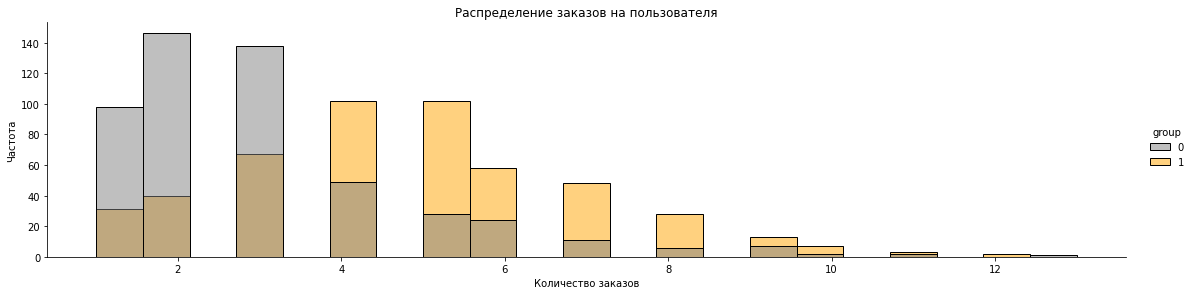

In [60]:
colors = {"0": "gray", "1": "Orange"}
sns.displot(data=count_action_user_id, x="count_action_user_id", hue="group", palette=colors.values(), height=4, aspect=4)
plt.title('Распределение заказов на пользователя')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')

**Violinplot**

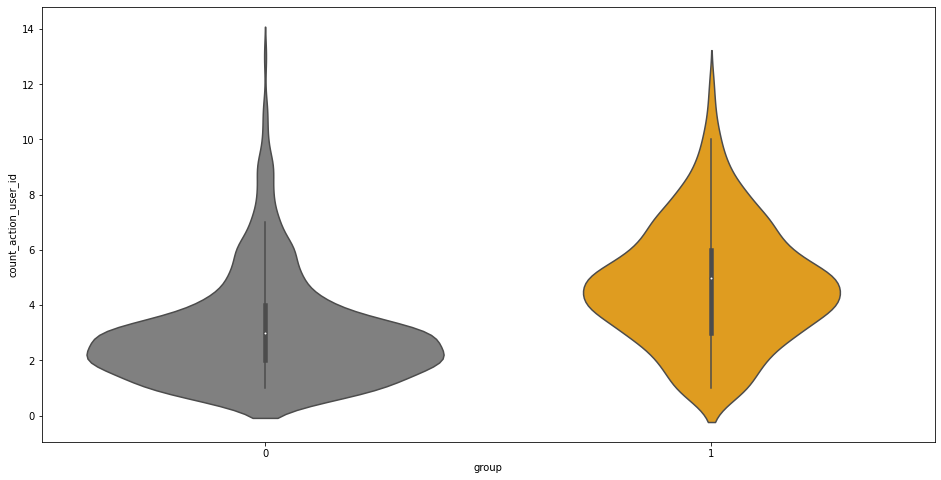

In [61]:
plt.figure(figsize=(16, 8))
colors = {"0": "gray", "1": "Orange"}
sns.violinplot(x='group', y='count_action_user_id', data=count_action_user_id, palette=colors.values())

**Q-Q plot**

In [62]:
group_0 = count_action_user_id.query('group == 0')
group_1 = count_action_user_id.query('group == 1')

Text(0, 0.5, 'Наблюдаемые квантили')

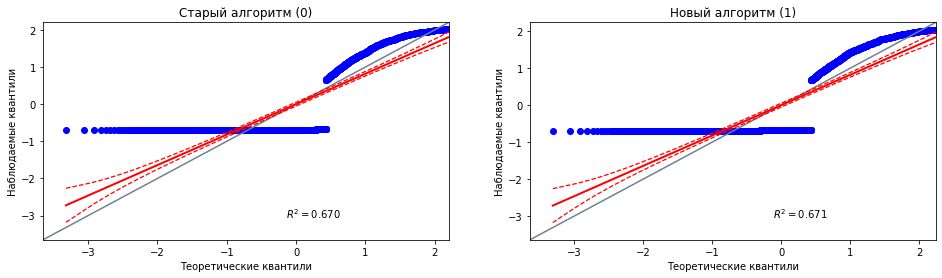

In [63]:
# Создаем фигуру с 1 строкой и 2 столбцами
fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Измените размер по вашему усмотрению

# Строим квантиль-квантиль графики на каждой из подсеток
pg.qqplot(group_0, dist='norm', ax=axes[0])  # График 1 в первой подсетке
pg.qqplot(group_1, dist='norm', ax=axes[1])  # График 2 во второй подсетке

# Настройте заголовки и метки осей, если это необходимо
axes[0].set_title('Старый алгоритм (0)')
axes[1].set_title('Новый алгоритм (1)')
axes[0].set_xlabel('Теоретические квантили')
axes[1].set_xlabel('Теоретические квантили')
axes[0].set_ylabel('Наблюдаемые квантили')
axes[1].set_ylabel('Наблюдаемые квантили')


**Тест Шапиро-Уилка**

In [64]:
# method Shapiro-Wilk test(default)
pg.normality(count_action_user_id, dv='count_action_user_id', group='group')

,W,pval,normal
0,0.827910,4.713437e-23,False
1,0.963444,7.850973e-10,False


**Вывод**

По результатам оценки, распределение `count_action_user_id` выручки по отдельному пользователю для старого и нового алгоритма отлично от нормального. Кроме того, согласно графику `violinplot` форма распределений группы 0 и 1 отличается. Наблюдается смещение тенденции в сторону увеличения количества заказов.

**Выбор метода для проверки гипотезы**

Поскольку распределение наблюдений в группах не прошли проверку на соответствие нормальному, форма распределений в группах отличается, принято в качестве метода проверки гипотезы использовать бутстрап на основе библиотеки `pingouin`.

In [65]:
group_0 = group_0.count_action_user_id
group_1 = group_1.count_action_user_id

In [66]:
def mean_diff(x, y):
    return abs(np.mean(x) - np.mean(y))

In [67]:
ci, bt = pg.compute_bootci(group_0, group_1, func=mean_diff, n_boot=10000, return_dist=True, seed=123)
print(round(mean_diff(group_0, group_1), 2), ci)
print(f"The bootstrap distribution has {bt.size} samples. The mean and standard " f"{np.mean(bt):.4f} ± {bt.std():.4f}")

1.77 [1.53 2.01]
The bootstrap distribution has 10000 samples. The mean and standard 1.7709 ± 0.1239


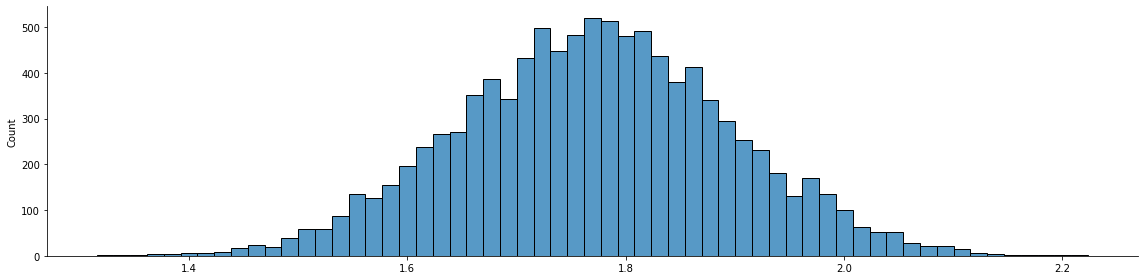

In [68]:
sns.displot(bt, height=4, aspect=4)

**Вывод**

При проверке 2 гипотезы, в соответствии с данными А/Б эксперемнта получены стат. значимые результаты.\
В данном случае, интервал [1.53 2.01] означает, что с 95% уровнем доверия 1.77 находится в диапазоне от 1.53 до 2.01.
Поскольку доверительный интервал по разнице средних значений не включает 0, достаточно оснований говорить о стат. значимых различиях.

Принимаем гипотизу H1 о работоспособности нового алгоритма и увеличении количества заказов по отдельному пользователю в среднем на 1.77 с доверительным интервалом [1.53 2.01].

## Проверка гипотезы 3

**Влияние нового алгоритма на:**

3. размер выручки
    - **H0** - новый алгорит не повлиял на увеличение выручки
    - **H1** - увеличение выручки связано с работой нового алгоритма

Проверим данные на соответствие нормальному закону распределения.

In [69]:
total_price_user_id.head()

,group,user_id,total_price_user_id
0,0,964,718.9
1,0,968,1590.7
2,0,969,681.9
3,0,972,546.4
4,0,975,1432.9


Text(11.288696289062514, 0.5, 'Частота')

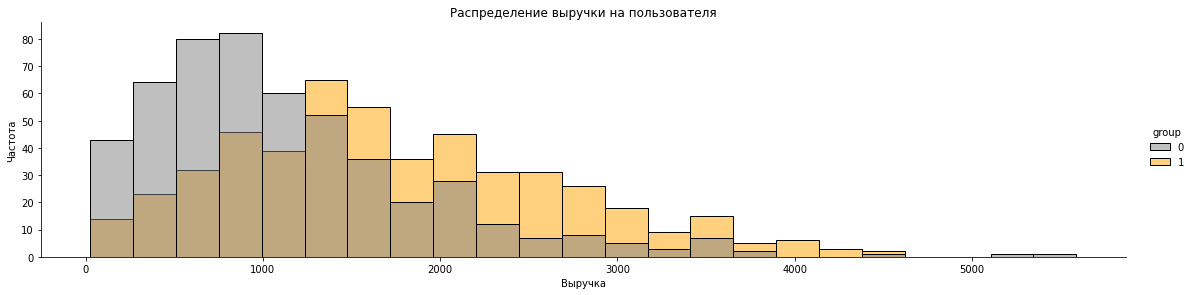

In [70]:
colors = {"0": "gray", "1": "Orange"}
sns.displot(data=total_price_user_id, x="total_price_user_id", hue="group", palette=colors.values(), height=4, aspect=4)
plt.title('Распределение выручки на пользователя')
plt.xlabel('Выручка')
plt.ylabel('Частота')

**Violinplot**

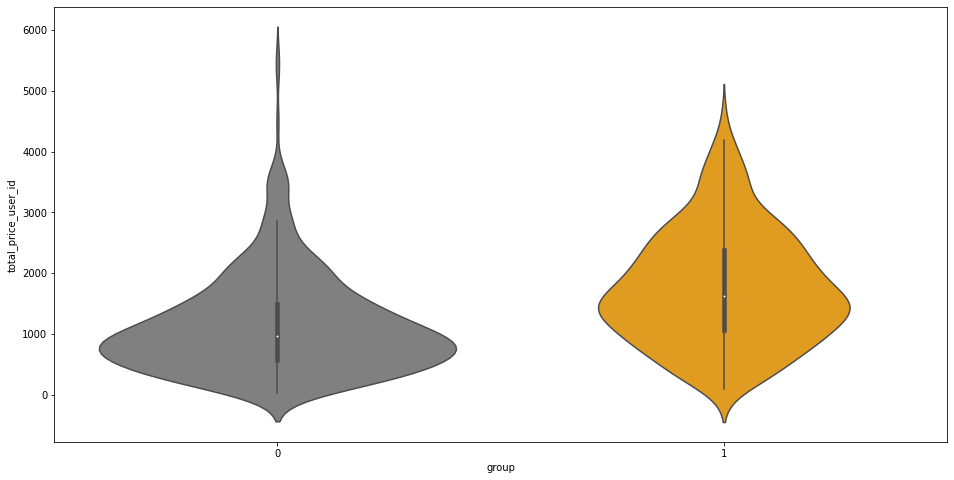

In [71]:
plt.figure(figsize=(16, 8))
colors = {"0": "gray", "1": "Orange"}
sns.violinplot(x='group', y='total_price_user_id', data=total_price_user_id, palette=colors.values())

**Q-Q plot**

In [72]:
group_0 = total_price_user_id.query('group == 0')
group_1 = total_price_user_id.query('group == 1')

Text(0, 0.5, 'Наблюдаемые квантили')

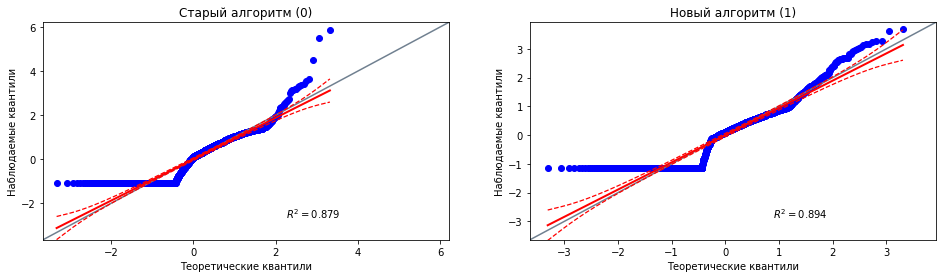

In [73]:
# Создаем фигуру с 1 строкой и 2 столбцами
fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Измените размер по вашему усмотрению

# Строим квантиль-квантиль графики на каждой из подсеток
pg.qqplot(group_0, dist='norm', ax=axes[0])  # График 1 в первой подсетке
pg.qqplot(group_1, dist='norm', ax=axes[1])  # График 2 во второй подсетке

# Настройте заголовки и метки осей, если это необходимо
axes[0].set_title('Старый алгоритм (0)')
axes[1].set_title('Новый алгоритм (1)')
axes[0].set_xlabel('Теоретические квантили')
axes[1].set_xlabel('Теоретические квантили')
axes[0].set_ylabel('Наблюдаемые квантили')
axes[1].set_ylabel('Наблюдаемые квантили')


**Тест Шапиро-Уилка**

In [74]:
# method Shapiro-Wilk test(default)
pg.normality(total_price_user_id, dv='total_price_user_id', group='group')

,W,pval,normal
0,0.888535,8.713837e-19,False
1,0.974877,1.408599e-07,False


**Вывод**

По результатам оценки, распределение `total_price_user_id` выручки по отдельному пользователю для старого и нового алгоритма отлично от нормального. Кроме того, согласно графику `violinplot` форма распределений группы 0 и 1 отличается. Наблюдается смещение тенденции в сторону увеличения выручки с отдельного прользователя.

**Выбор метода для проверки гипотезы**

Поскольку распределение наблюдений в группах не прошли проверку на соответствие нормальному, форма распределений в группах отличается, принято в качестве метода проверки гипотезы использовать бутстрап на основе библиотеки `pingouin`.

In [75]:
group_0 = group_0.total_price_user_id
group_1 = group_1.total_price_user_id

In [76]:
def mean_diff(x, y):
    return abs(np.mean(x) - np.mean(y))

In [77]:
ci, bt = pg.compute_bootci(group_0, group_1, func=mean_diff, n_boot=10000, return_dist=True, seed=123)
print(round(mean_diff(group_0, group_1), 2), ci)
print(f"The bootstrap distribution has {bt.size} samples. The mean and standard " f"{np.mean(bt):.4f} ± {bt.std():.4f}")

614.19 [505.67 723.43]
The bootstrap distribution has 10000 samples. The mean and standard 615.1971 ± 55.5835


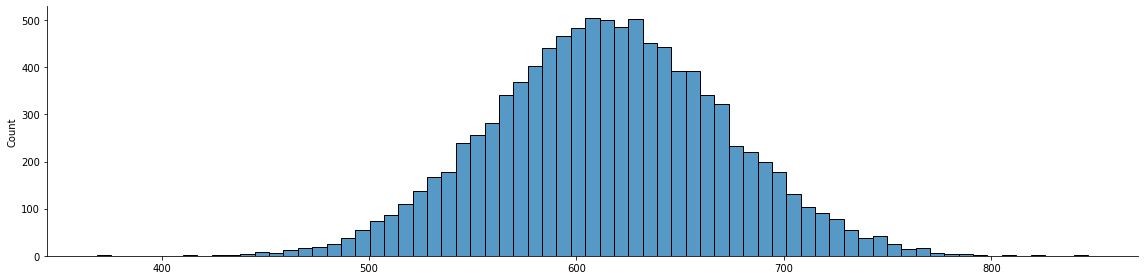

In [78]:
sns.displot(bt, height=4, aspect=4)

**Вывод**

При проверке 3 гипотезы, в соответствии с данными А/Б эксперемнта получены стат. значимые результаты.\
В данном случае, интервал [505.67 723.43] означает, что с 95% уровнем доверия 614.19 находится в диапазоне от 505.67 до 723.43.
Поскольку доверительный интервал по разнице средних значений не включает 0, достаточно оснований говорить о стат. значимых различиях.

Принимаем гипотизу H1 о работоспособности нового алгоритма и увеличении выручки по отдельному пользователю в среднем на 614.19 с доверительным интервалом [505.67 723.43].

## Проверка гипотезы 4

**Влияние нового алгоритма на:**

4. размер потребительской корзины
    - **H0** - новый алгорит не повлиял на увеличение размера потребительской корзины
    - **H1** - увеличение размера потребительской корзины связано с работой нового алгоритма

Проверим данные на соответствие нормальному закону распределения.

In [79]:
count_product_user_id.head()

,group,user_id,count_product_user_id
0,0,964,8
1,0,968,11
2,0,969,8
3,0,972,5
4,0,975,11


Text(11.288696289062514, 0.5, 'Частота')

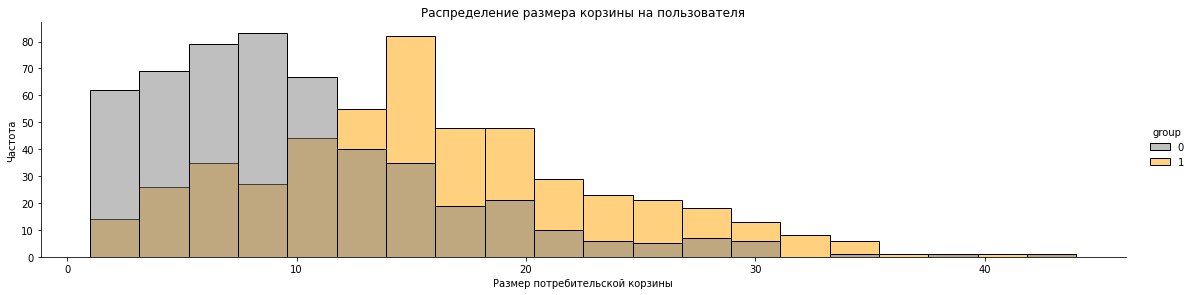

In [80]:
colors = {"0": "gray", "1": "Orange"}
sns.displot(data=count_product_user_id, x="count_product_user_id", hue="group", palette=colors.values(), height=4, aspect=4)
plt.title('Распределение размера корзины на пользователя')
plt.xlabel('Размер потребительской корзины')
plt.ylabel('Частота')

**Violinplot**

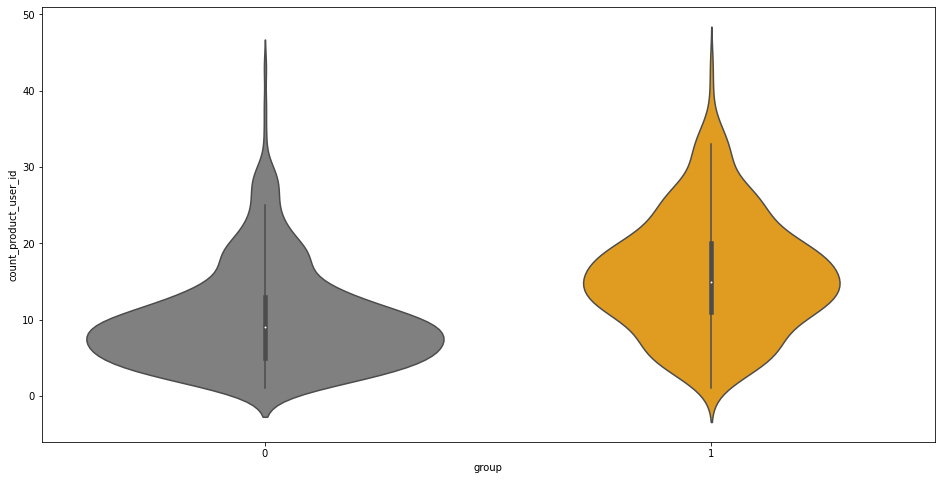

In [81]:
plt.figure(figsize=(16, 8))
colors = {"0": "gray", "1": "Orange"}
sns.violinplot(x='group', y='count_product_user_id', data=count_product_user_id, palette=colors.values())

**Q-Q plot**

In [82]:
group_0 = count_product_user_id.query('group == 0')
group_1 = count_product_user_id.query('group == 1')

Text(0, 0.5, 'Наблюдаемые квантили')

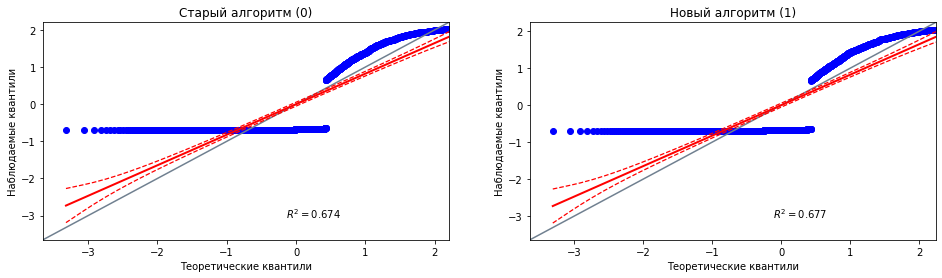

In [83]:
# Создаем фигуру с 1 строкой и 2 столбцами
fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Измените размер по вашему усмотрению

# Строим квантиль-квантиль графики на каждой из подсеток
pg.qqplot(group_0, dist='norm', ax=axes[0])  # График 1 в первой подсетке
pg.qqplot(group_1, dist='norm', ax=axes[1])  # График 2 во второй подсетке

# Настройте заголовки и метки осей, если это необходимо
axes[0].set_title('Старый алгоритм (0)')
axes[1].set_title('Новый алгоритм (1)')
axes[0].set_xlabel('Теоретические квантили')
axes[1].set_xlabel('Теоретические квантили')
axes[0].set_ylabel('Наблюдаемые квантили')
axes[1].set_ylabel('Наблюдаемые квантили')


**Тест Шапиро-Уилка**

In [84]:
# method Shapiro-Wilk test(default)
pg.normality(count_product_user_id, dv='count_product_user_id', group='group')

,W,pval,normal
0,0.896944,4.579424e-18,False
1,0.979967,2.205802e-06,False


**Вывод**

По результатам оценки распределение `count_product_user_id` размер потребительской корзины по отдельному пользователю для старого и нового алгоритма отлично от нормального. Кроме того, согласно графику `violinplot` форма распределений группы 0 и 1 отличается. Наблюдается смещение тенденции в сторону увеличения размера корзины отдельного пользователя.

**Выбор метода для проверки гипотезы**

Поскольку распределение наблюдений в группах не прошли проверку на соответствие нормальному, форма распределений в группах отличается, принято в качестве метода проверки гипотезы использовать бутстрап на основе библиотеки `pingouin`.

In [85]:
group_0 = group_0.count_product_user_id
group_1 = group_1.count_product_user_id

In [86]:
def mean_diff(x, y):
    return abs(np.mean(x) - np.mean(y))

In [87]:
ci, bt = pg.compute_bootci(group_0, group_1, func=mean_diff, n_boot=10000, return_dist=True, seed=123)
print(round(mean_diff(group_0, group_1), 2), ci)
print(f"The bootstrap distribution has {bt.size} samples. The mean and standard " f"{bt.mean():.4f} ± {bt.std():.4f}")

5.96 [5.07 6.81]
The bootstrap distribution has 10000 samples. The mean and standard 5.9766 ± 0.4407


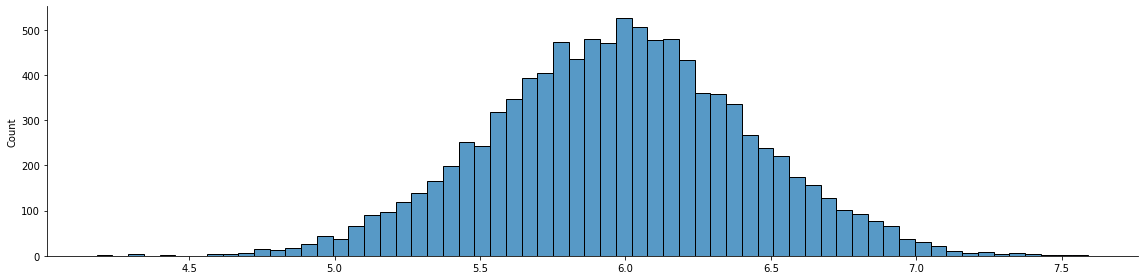

In [88]:
sns.displot(bt, height=4, aspect=4)

**Вывод**

При проверке 4 гипотезы, в соответствии с данными А/Б эксперемнта получены стат. значимые результаты.\
В данном случае, интервал [5.07 6.81] означает, что с 95% уровнем доверия 5.96 находится в диапазоне от 5.07 до 6.81.
Поскольку доверительный интервал по разнице средних значений не включает 0, достаточно оснований говорить о стат. значимых различиях.

Принимаем гипотизу H1 о работоспособности нового алгоритма и увеличении размера корзины по отдельному пользователю в среднем на 5,96 с доверительным интервалом [5.07 6.81].

## Заключение

По результаам проверки гипотез 1, 2, 3, 4. Принято решение о применении нового алгоритма ко всем пользователям.\
Гипотеза 1 о возможном негативном влиянии нового алгоритма не подтвердилась. Проверка гипотез 2, 3, 4 показала стат. значимые результаты положительно влияющие на бизнес.